## LikelihoodRatio Map with class structure

Let's start with uploading required libraries

In [1]:
from vip_hci.fits import open_fits
from vip_hci.var import frame_center
from vip_hci.fm import normalize_psf
from hciplot import plot_frames
import numpy as np
import vip_hci as vip
from vip_hci.psfsub import pca
from likelihoodmap_generator import LikelihoodRatioMap

We continue with uploading the datasets.

In [2]:
adi_cube = '../datasets/sphere_k1_51eri_2016'
adi_pa = '../datasets/sphere_k1_51eri_2016'
adi_psf = '../datasets/sphere_k1_51eri_2016_psf'

dataset = vip.hci_dataset.Dataset(
    cube=vip.fits.open_fits(adi_cube, verbose=False),
    angles=vip.fits.open_fits(adi_pa, verbose=False, n=1),
    psf=vip.fits.open_fits(adi_psf,verbose=False)
)

dataset.normalize_psf(verbose=False, size=21)
dataset.crop_frames(100)

Cube array shape: (256, 200, 200)
Angles array shape: (256,)
PSF array shape: (50, 50)
Normalized PSF array shape: (21, 21)
The attribute `psfn` contains the normalized PSF
`fwhm` attribute set to
4.863
New shape: (256, 100, 100)


Before constructing likelihoodratio map, we should run an algorithm for PSF subtraction. To do so, let's use the most common method: PCA.

In [3]:
res_pca = pca(dataset.cube, dataset.angles, ncomp=20, imlib='opencv', full_output=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-12-18 01:13:13
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 134.732 GB
System available memory = 127.470 GB
Done vectorizing the frames. Matrix shape: (256, 10000)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.170543
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:00.451904
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [4]:
frame, _, L, res_cube, res_cube_der = res_pca

After we obtain the residual cube, we can calculate likelihoodratio map.

In [5]:
likelihood_map_eri51_l2 = LikelihoodRatioMap(res_cube, dataset.angles, dataset.psfn, fwhm=dataset.fwhm, norm=2)

In [6]:
likelihood_map_eri51_l2.generate(n_jobs=10)

100%|██████████| 6744/6744 [01:33<00:00, 72.07it/s]


Finally, let's visualise the map. Here, white circle repsresents the planet location.

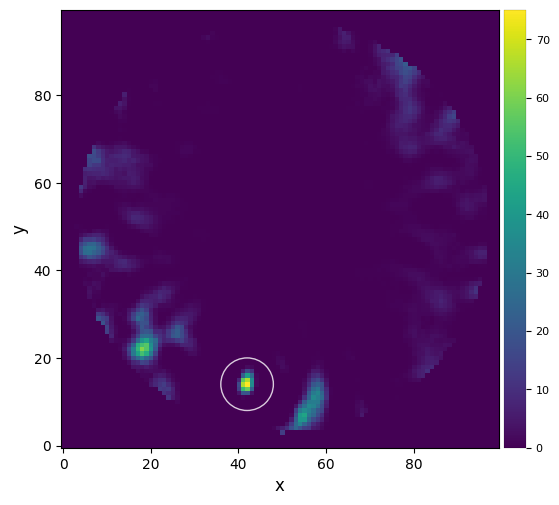

In [8]:
plot_frames(likelihood_map_eri51_l2.lrmap, circle=(42, 14))

We can run the same algorithm with $\ell_1$ norm (this is the one we suggested.)

In [9]:
likelihood_map_eri51_l1 = LikelihoodRatioMap(res_cube, dataset.angles, dataset.psfn, fwhm=dataset.fwhm, norm=1)

In [10]:
likelihood_map_eri51_l1.generate(n_jobs=10)

100%|██████████| 6744/6744 [01:27<00:00, 76.78it/s]


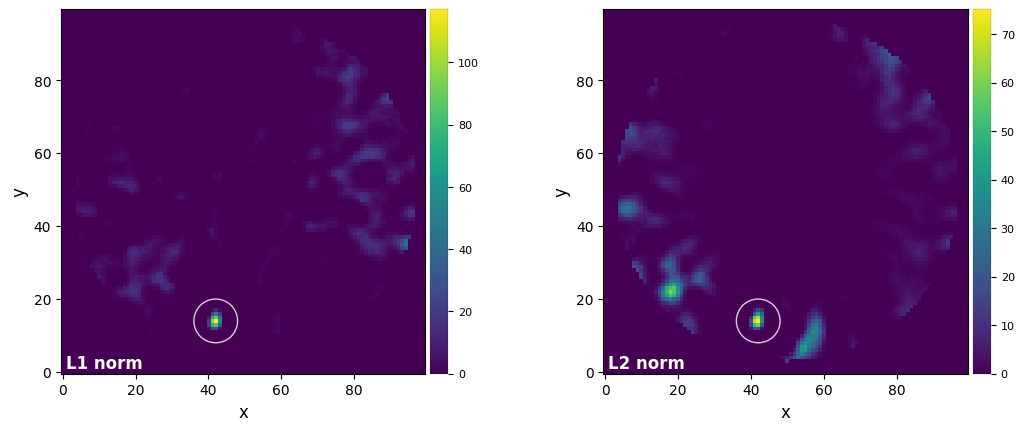

In [13]:
plot_frames((likelihood_map_eri51_l1.lrmap, likelihood_map_eri51_l2.lrmap), label=('L1 norm', 'L2 norm'), circle=(42,14))

We see that likelihood ratio map with L1 norm (or $\ell_1$ norm) finds the planet, while L2 norm has same extra high values in nonplanet pixels. 